# Data

We will load the data from a specific path.

In [1]:
import pandas as pd

dataset = pd.read_csv("../data/1a_3d_200s_0.5ir_4321_2025-08-10.csv")

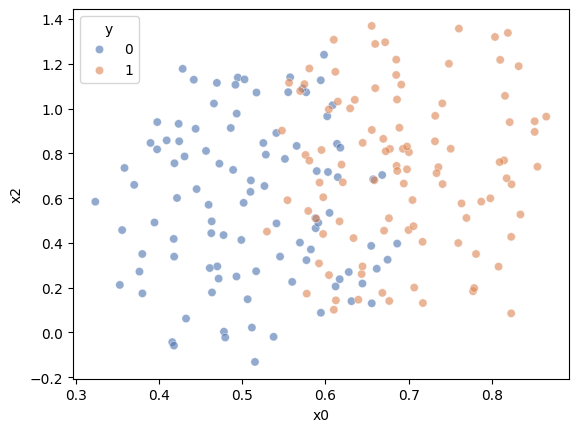

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    x=dataset["x0"], y=dataset["x2"], alpha=0.6, hue=dataset["y"], palette="deep"
)
plt.show()

In [3]:
X_sample = dataset.drop(columns=["y"])
y_sample = dataset["y"]

## Preprocessing step

Based on feature correlation.

In [4]:
from kernel_trainer.preprocess import Preprocessor

# Number of dimensions
num_dimensions = 2
prep = Preprocessor(num_dimensions, mode="pca", scale=True)
X_reduced = prep.fit_transform(X_sample)

In [5]:
from sklearn.model_selection import train_test_split

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_sample, test_size=0.20, random_state=42
)

# Kernel trainer

In [7]:
from kernel_trainer import kernel_generator

n_pop = 5
n_gen = 2
chain = 6
mutation_pb = 0.6
cx_prob = 0.3

pop_final, log = kernel_generator(
    X_train,
    y_train,
    num_pop=n_pop,
    ngen=n_gen,
    cxpb=cx_prob,
    mutpb=mutation_pb,
    chain_size=chain,
    penalize_complexity=False,
)

2026-02-04 at 17:34:26 | INFO | gen	nevals	ts	avg     	std      	min     	max     
0  	5     	0 	0.372603	0.0374114	0.314927	0.417985


  0%|          | 0/2 [00:00<?, ?it/s]

2026-02-04 at 17:37:33 | INFO | 1  	5     	187.687	0.404689	0.0250451	0.38128 	0.435276


 50%|█████     | 1/2 [03:07<03:07, 187.69s/it]

2026-02-04 at 17:38:50 | INFO | 2  	2     	76.0934	0.414428	0.0266371	0.37116 	0.435276


100%|██████████| 2/2 [04:23<00:00, 131.89s/it]


In [8]:
best = pop_final[0]
best

Individual([2, 1, 1, 0, 3, 3])

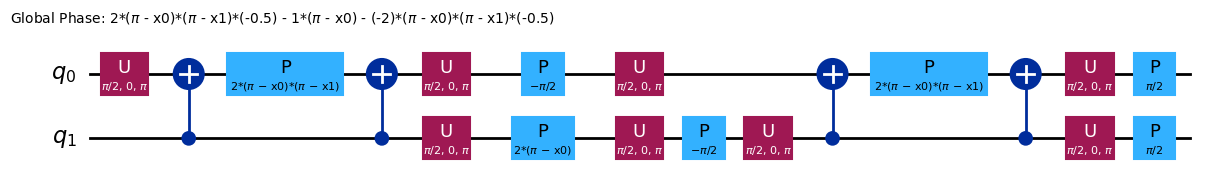

In [9]:
from qiskit import QuantumCircuit
from kernel_trainer.kernels.quantum import ind_to_qiskit_kernel

qc = QuantumCircuit(X_train.shape[1])

kernel_auto = ind_to_qiskit_kernel(best, qc)
kernel_auto.feature_map.decompose().draw("mpl", fold=-1)

In [10]:
kernel_auto.feature_map.depth()

14

In [11]:
kernel_auto.feature_map.num_nonlocal_gates()

4

In [12]:
ops = kernel_auto.feature_map.count_ops()
sum([n for _, n in ops.items()])

19

(<Figure size 900x300 with 1 Axes>, <Axes: >)


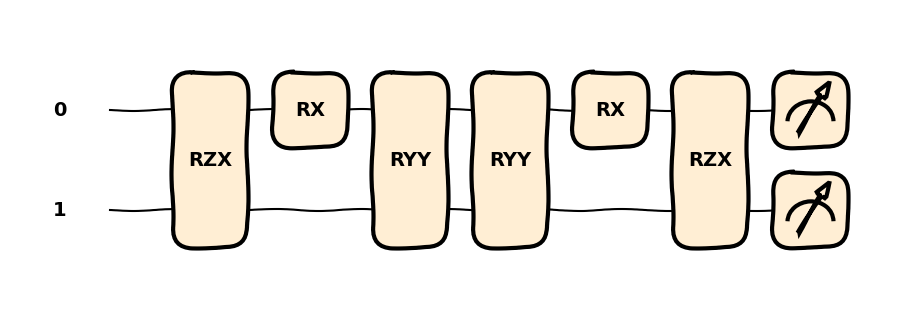

In [13]:
import pennylane as qml
from kernel_trainer.kernels.quantum import ind_to_pennylane_kernel

qml.drawer.use_style("sketch")

dev = qml.device("lightning.qubit", wires=num_dimensions)

kernel_auto = ind_to_pennylane_kernel(pop_final[0], dev)
print(qml.draw_mpl(kernel_auto)(X_train[0], X_train[0]))

In [14]:
specs = qml.specs(qnode=kernel_auto)(X_train[0], X_train[0])
specs["resources"]

Total wire allocations: 2
Total gates: 6
Circuit depth: 6

Gate types:
  PauliRot: 6

Measurements:
  probs(all wires): 1


In [15]:
specs["resources"].depth

6

In [16]:
specs["resources"].gate_types["PauliRot"]

6

Now running with Pennylane backend.

In [18]:
backend = "pennylane"

pop_final, log = kernel_generator(
    X_train,
    y_train,
    backend=backend,
    num_pop=n_pop,
    ngen=n_gen,
    cxpb=cx_prob,
    mutpb=mutation_pb,
    chain_size=chain,
)

2026-02-04 at 17:57:39 | INFO | gen	nevals	ts	avg     	std      	min     	max     
0  	5     	0 	0.371537	0.0144001	0.343897	0.383298


  0%|          | 0/2 [00:00<?, ?it/s]

2026-02-04 at 17:58:43 | INFO | 1  	4     	63.6006	0.422794	0.0667286	0.343897	0.516812


 50%|█████     | 1/2 [01:03<01:03, 63.60s/it]

2026-02-04 at 17:59:15 | INFO | 2  	2     	32.0359	0.460657	0.0628924	0.351323	0.516812


100%|██████████| 2/2 [01:35<00:00, 47.82s/it]


(<Figure size 900x300 with 1 Axes>, <Axes: >)


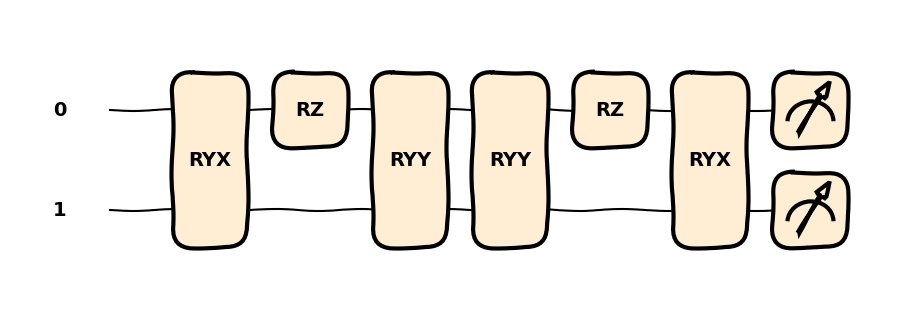

In [19]:
kernel_auto = ind_to_pennylane_kernel(pop_final[0], dev)
print(qml.draw_mpl(kernel_auto)(X_train[0], X_train[0]))